# HW2P2: Face Classification and Verification


# Preliminaries

In [1]:
!nvidia-smi # to see what GPU you have

Tue Oct 11 16:37:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install wandb --quiet

     |████████████████████████████████| 1.9 MB 8.8 MB/s 
     |████████████████████████████████| 162 kB 54.2 MB/s 
     |████████████████████████████████| 182 kB 52.1 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 162 kB 37.3 MB/s 
     |████████████████████████████████| 158 kB 57.0 MB/s 
     |████████████████████████████████| 157 kB 60.9 MB/s 
     |████████████████████████████████| 157 kB 50.9 MB/s 
     |████████████████████████████████| 157 kB 64.8 MB/s 
     |████████████████████████████████| 157 kB 58.7 MB/s 
     |████████████████████████████████| 157 kB 27.2 MB/s 
     |████████████████████████████████| 157 kB 55.9 MB/s 
     |████████████████████████████████| 157 kB 57.1 MB/s 
     |████████████████████████████████| 156 kB 57.2 MB/s 


In [3]:
import torch
from torchsummary import summary
import torch.nn as nn
import torchvision #This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [4]:
from google.colab import drive # Link your drive if you are a colab user
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it her

Mounted at /content/drive



# Download Data from Kaggle

In [ ]:
#Install Kaggle API
!pip install --upgrade --force-reinstall --no-deps kaggle 
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"","key":""}') 
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!mkdir '/content/data'
!kaggle competitions download -c 11-785-f22-hw2p2-classification
!unzip -qo '11-785-f22-hw2p2-classification.zip' -d '/content/data'
!kaggle competitions download -c 11-785-f22-hw2p2-verification
!unzip -qo '11-785-f22-hw2p2-verification.zip' -d '/content/data'

 99% 2.35G/2.37G [00:19<00:00, 205MB/s]
100% 2.37G/2.37G [00:19<00:00, 128MB/s]
 71% 12.0M/16.8M [00:00<00:00, 56.4MB/s]
100% 16.8M/16.8M [00:00<00:00, 70.7MB/s]


# Data Summary


 Dataset summary: 

      train_data[i][0]: tensor, shape(3,224,224)
      train_Data[i][1]: class

    total class: 7000
    number of train data: 140000
    number of train data subset: 70000

    torchvision.datasets.ImageFolder: same class picture in same fold

Data_loader summary:

    if data in train_loader:
        data[0]: bach_size x train_data[i][0], shape(batch_size, 3,224,224)
        data[1]: bach_size x class[i][0], shape(batch_size)
    
    train_subset:
    mean: tensor([0.5131, 0.4034, 0.3522])
    std: tensor([0.3071, 0.2699, 0.2587])
    

In [ ]:
DATA_DIR = '/content/data/11-785-f22-hw2p2-classification/'# TODO: Path where you have downloaded the data
TRAIN_DIR = os.path.join(DATA_DIR, "classification/train_subset") 
train_transforms = torchvision.transforms.Compose([ 
                    torchvision.transforms.ToTensor() 
                    ])
train_data = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms)
train_data_loader = torch.utils.data.DataLoader(train_data, 
                                                # batch size is whole datset
                                                batch_size=len(train_data),
                                               # batch_size = 2, 
                                                shuffle=False, 
                                                num_workers=0)

In [ ]:
def mean_std(loader):
  image, label = next(iter(loader))
  mean, std = image.mean([0,2,3]), image.std([0,2,3])
  return mean, std

In [ ]:
mean, std =mean_std(train_data_loader)
print(mean)
print(std)

In [ ]:
def batch_mean_and_sd(loader):
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)
    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
    return mean,std

In [ ]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision.transforms as T

orig_img = Image.open('//content/data/11-785-f22-hw2p2-classification/classification/dev/n000002/0269_01.jpg')
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]
    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

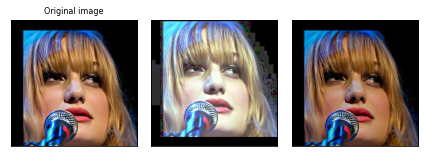

In [ ]:
trans = torchvision.transforms.RandAugment(num_ops = 5, magnitude = 5)
trans_imgs = [trans(orig_img) for _ in range(2)]
plot(trans_imgs)

# Classification Dataset

In [7]:
# Classification dataset direction
DATA_DIR = '/content/data/11-785-f22-hw2p2-classification/'# TODO: Path where you have downloaded the data
TRAIN_DIR = os.path.join(DATA_DIR, "classification/train") 
TRAIN_subset_DIR = os.path.join(DATA_DIR, "classification/train_subset") 
VAL_DIR = os.path.join(DATA_DIR, "classification/dev")
TEST_DIR = os.path.join(DATA_DIR, "classification/test")

In [8]:
# Transforms using torchvision - Refer https://pytorch.org/vision/stable/transforms.html
# TO tensor
# ResNet2: only use to tensor
train_transforms = torchvision.transforms.Compose([ 
                    torchvision.transforms.ToTensor() 
                    ])

train_transforms_rand = torchvision.transforms.Compose([ 
                    torchvision.transforms.RandAugment(num_ops = 3, magnitude = 3),
                    torchvision.transforms.ToTensor() 
                    ])

train_transforms_flip = torchvision.transforms.Compose([ 
                    torchvision.transforms.RandomHorizontalFlip(p=0.5),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        mean = [0.5131, 0.4034, 0.3522],
                        std = [0.3071, 0.2699, 0.2587])
                    ])
train_transforms_flip_rand = torchvision.transforms.Compose([ 
                    torchvision.transforms.RandomHorizontalFlip(p=1),
                    torchvision.transforms.RandAugment(num_ops = 3, magnitude = 3),
                    torchvision.transforms.ToTensor() 
                    ])

train_transform_inone = torchvision.transforms.Compose([ 
                    torchvision.transforms.RandomHorizontalFlip(p=0.5),
                    torchvision.transforms.RandAugment(num_ops = 3, magnitude = 3),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        mean = [0.5131, 0.4034, 0.3522],
                        std = [0.3071, 0.2699, 0.2587])
                    ])
train_transform_choose1 = torchvision.transforms.Compose([ 
                    torchvision.transforms.RandomHorizontalFlip(p=0.5),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        mean = [0.5131, 0.4034, 0.3522],
                        std = [0.3071, 0.2699, 0.2587])
                    ])

train_transform_choose2 = torchvision.transforms.Compose([ 
                    torchvision.transforms.RandomHorizontalFlip(p=0.5),
                    torchvision.transforms.RandomRotation([-10, 10]),                    
                    torchvision.transforms.GaussianBlur(11),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        mean = [0.5131, 0.4034, 0.3522],
                        std = [0.3071, 0.2699, 0.2587])
                    ])

val_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.Normalize(
                                                  mean = [0.5131, 0.4034, 0.3522],
                                                  std= [0.3071, 0.2699, 0.2587]) 
                                                 ])

In [9]:
train_data = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms)
train_dataset_rand = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms_rand)
train_dataset_flip = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms_flip)
train_dataset_flip_rand = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms_flip_rand)
#train_data 
#train_dataset=  torch.utils.data.ConcatDataset([train_data, train_dataset_flip, train_dataset_rand, train_dataset_flip_rand])
# train_dataset =  torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transform_inone)

# train_dataset1 = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transform_choose1)
# train_dataset2 = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transform_choose2)
# train_dataset=  torch.utils.data.ConcatDataset([train_dataset1, train_dataset2])
train_dataset = train_data


In [10]:
val_dataset = torchvision.datasets.ImageFolder(VAL_DIR, transform = val_transforms)

# Helper function

In [11]:
def validate(model, dataloader, criterion):
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, 
                     leave=False, desc='Val', ncols=5)
    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        # Move images to device
        images, labels = images.to(device), labels.to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)
        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)
        batch_bar.update()
        
    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss, num_correct

In [12]:
def train(model, dataloader, optimizer, criterion, scaler):
    model.train()
    # Progress Bar 
    #Use coloured version of progress bars
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, 
                     leave=False, position=0, desc='Train', ncols=5) 
    num_correct = 0
    total_loss = 0
    for i, (images, labels) in enumerate(dataloader):
        optimizer.zero_grad() # Zero gradients
        images, labels = images.to(device), labels.to(device)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            ### Forward Propagation 
            outputs = model(images)
            ### Loss Calculation
            loss = criterion(outputs, labels)
        # Update no. of correct predictions & loss as we iterate

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())
        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct,
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        
        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # You may want to call some schdulers inside the train function. What are these?
        batch_bar.update() # Update tqdm bar
        scheduler.step() # for consine schedule
    batch_bar.close() # You need this to close the tqdm bar

    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))

    return acc, total_loss, num_correct

In [13]:
def train_all_epoch(model, train_loader, val_loader, optimizer, criterion, 
                    scheduler, scaler):
    best_valacc = 0.0
    for epoch in range(config['epochs']):
      curr_lr = float(optimizer.param_groups[0]['lr']) # get current learning rate
      # train data for one epoch
      train_acc, train_loss, train_num_correct = train(model, train_loader, optimizer, criterion,
                                    scaler)
      print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
          epoch + 1,
          config['epochs'],
          train_acc,
          train_loss,
          curr_lr))
      val_acc, val_loss, val_num_correct = validate(model, val_loader, criterion)
      print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

      wandb.log({"train_loss":train_loss, 'train_Acc': train_acc,  'train_num_correct': train_num_correct,
                 'validation_Acc':val_acc, 'validation_loss': val_loss, 'val_num_correct': val_num_correct,
                 "learning_Rate": curr_lr})
      
      # If you are using a scheduler in your train function within your iteration loop, you may want to log
      # your learning rate differently 
      # #Save model in drive location if val_acc is better than best recorded val_acc
      if val_acc >= best_valacc:
        #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
        print("Saving model")
        # Saving the model and optimizer states
        torch.save({
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              #'scheduler_state_dict':scheduler.state_dict()
              'val_acc': val_acc, 
               'epoch': epoch
              }, "Model")
        # model_artifact = wandb.Artifact(config['model'], type='model')
        # # Adding model file to Artifact
        # model_artifact.add_file("Model")
        # # Saving Artifact to WandB
        # run.log_artifact(model_artifact)
        torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  #'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc, 
                  'epoch': epoch}, './checkpoint.pth')
        wandb.save('checkpoint.pth')

        best_valacc = val_acc
        # You may find it interesting to exlplore Wandb Artifcats to version your models
    run.finish()

#Network

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.ZeroPad2d(3 // 2),
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride),
                        nn.BatchNorm2d(out_channels),
                        nn.GELU(),

                        nn.ZeroPad2d(3 // 2),
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.GELU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [16]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 7000):
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.ZeroPad2d(7 // 2),
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2),
                        nn.BatchNorm2d(64),
                        nn.GELU(),
                        
                        nn.ZeroPad2d(3 // 2),
                        nn.MaxPool2d(kernel_size = 3, stride = 2)
                        )
        self.cur_channel = 64
        self.layer0 = self.make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self.make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self.make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self.make_layer(block, 512, layers[3], stride = 2)
        self.layer4 = self.make_layer(block, 1024, layers[4], stride = 2)
        #self.layer5 = self.make_layer(block, 2048, layers[4], stride = 2)

        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.Flatten = nn. Flatten()

        self.cls_layer = nn.Sequential(
            nn.Linear(9216, num_classes)
        )
        
    def make_layer(self, block, out_channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.cur_channel != out_channel:
            downsample = nn.Sequential(
                nn.Conv2d(self.cur_channel, out_channel, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channel),
            )
        layers = []
        layers.append(block(self.cur_channel, out_channel, stride, downsample))
        self.cur_channel = out_channel
        for i in range(1, block_num):
            layers.append(block(self.cur_channel, out_channel))

        return nn.Sequential(*layers)
    
    
    def forward(self, x, return_feats=False):
        x = self.conv1(x)
        # ResNet
        x = self.layer0(x) #64
        x = self.layer1(x) #128
        x = self.layer2(x) #256
        x = self.layer3(x) #512
        x = self.layer4(x) #1024
        #x = self.layer5(x) #2048

        x = self.avgpool(x)
        feats = self.Flatten(x)
        out = self.cls_layer(feats)
        if return_feats:
            return feats
        else:
            return out

In [17]:
model = ResNet(ResidualBlock, [3, 6, 9, 6, 3]).to(device)

In [ ]:
summary(model, (3, 224, 224))

# Configs

In [19]:
config = {
    'epochs': 40,
    'batch_size' : 64 ,
    'drop_out': 0,
    'lr' : 0.1,
    'lr_schedule': 'CosineAnnealing',#'CosineAnnealing', #'StepLR', 'ReduceLROnPlateau', 'Exponential', 'CosineAnnealing'
    'optimizer': 'SGD',#'Nesterov',#'Adam', #'SGD', 'RMSProp'
    'weight_decay': 1e-4,
    'model': "ResNet_GELU",
    #'initial':'kaiming_uniform'
    # Add more as you need them - e.g dropout values, weight decay, scheduler parameters
}

# Wandb

In [20]:
wandb.login(key="4c3160d9590e0bd0ce427f907eeaef7b8d095beb")  #API Key is in your wandb account, under settings (wandb.ai/settings)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = config['model'], ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    project="", entity="",
    config = config)

# Save data to Wandb

In [ ]:
### Save your model architecture as a string with str(model) 
model_arch = str(model)

### Save it in a txt file 
arch_file = open("model_arch.txt", "w")
file_write = arch_file.write(model_arch)
file_write = arch_file.write("\n")
file_write = arch_file.write("parameter setting:\n")
for key, value in config.items(): 
        arch_file.write('%s:%s\n' % (key, value))
arch_file.close()

### log it in your wandb run with wandb.save()
wandb.save('model_arch.txt')

# Setup everything for training

## Data load

In [ ]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = config['batch_size'], 
                                           shuffle = True,num_workers = 4, pin_memory = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = config['batch_size'], 
                                         shuffle = False, num_workers = 2)

## Setup other things

In [24]:
#model = Network().to(device)
criterion = nn.CrossEntropyLoss()# TODO: What loss do you need for a multi class classification problem?
#optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], 
                             momentum=0.9, weight_decay=config['weight_decay'])
# TODO: Implement a scheduler (Optional but Highly Recommended)
# You can try ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader),
                                                          eta_min=1e-2, last_epoch=- 1, verbose=False)
scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you
# It is useful only in the case of compatible GPUs such as T4/V100

In [ ]:
weights_file = wandb.restore('ResNet_ori_flip/checkpoint.pth')

In [ ]:
# Define model
model = ResNet(ResidualBlock, [3, 6, 9, 6, 3]).to(device)
# Load model state
model.load_state_dict(torch.load('/content/drive/MyDrive/11-785-s22/hw/hw2p2/check/checkpoint.pth')['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Defining Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], 
                             momentum=0.9, weight_decay=config['weight_decay'])
# Load optimizer state
optimizer.load_state_dict(torch.load('')['optimizer_state_dict'])

# Experiments

In [25]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

In [ ]:
train_all_epoch(model, train_loader, val_loader, 
                optimizer, criterion, scheduler,
                scaler)

In [ ]:
val_acc, val_loss, val_num_correct = validate(model, val_loader, criterion)

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

# Classification Task: Testing

## Load Test Data

In [ ]:
# You can do this with ImageFolder as well, but it requires some tweaking
class ClassificationTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

In [ ]:
test_dataset = ClassificationTestDataset(TEST_DIR, transforms = val_transforms) #Why are we using val_transforms for Test Data?
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False,
                         drop_last = False, num_workers = 2)

## Testing

In [ ]:
def test(model,dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []
  
  for i, (images) in enumerate(dataloader):
      # TODO: Finish predicting on the test set.
      images = images.to(device)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)
      
      batch_bar.update()
      
  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

### Generate csv to submit to Kaggle

In [ ]:
with open("classification_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

# Verification Task: Validation

The verification task consists of the following generalized scenario:
- You are given X unknown identitites 
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 1000 known identities, and 1000 unknown identities. The 1000 unknown identities are split into dev (200) and test (800). Your goal is to compare the unknown identities to the 1000 known identities and assign an identity to each image from the set of unknown identities. 

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities. 

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [ ]:
known_regex = "/content/data/verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))] 
# This obtains the list of known identities from the known folder

unknown_regex = "/content/data/verification/unknown_dev/*" #Change the directory accordingly for the test set

# We load the images from known and unknown folders
unknown_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_images = torch.stack([transforms(x) for x in unknown_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6) 

In [ ]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'): 

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size
        
        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(device), return_feats=True) #Get features from model         
        unknown_feats.append(unknown_feat)
        batch_bar.update()
    
    batch_bar.close()
    
    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    
    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size] 
        with torch.no_grad():
              known_feat = model(known_batch.float().to(device), return_feats=True)
          
        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    predictions = similarity_values.argmax(0).cpu().numpy() #Why are we doing an argmax here?

    # Map argmax indices to identity strings
    pred_id_strings = [known_paths[i] for i in predictions]
    
    if mode == 'val':
      true_ids = pd.read_csv('/content/data/verification/dev_identities.csv')['label'].tolist()
      accuracy = accuracy_score(pred_id_strings, true_ids)
      print("Verification Accuracy = {}".format(accuracy))
    
    return pred_id_strings

In [ ]:
pred_id_strings = eval_verification(unknown_images, known_images, model, similarity_metric, config['batch_size'], mode='val')

## Test verification

In [ ]:
unknown_regex = "/content/data/verification/unknown_test/*" #Change the directory accordingly for the test set
# We load the images from known and unknown folders
unknown_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_regex)))]
# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])
unknown_images = torch.stack([transforms(x) for x in unknown_images])
#Print your shapes here to understand what we have done
# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6) 

In [ ]:
pred_id_strings = eval_verification(unknown_images, known_images, model, similarity_metric, config['batch_size'], mode='test')

In [ ]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

# Upload CSV to Kaggle

In [ ]:
## Submit to kaggle competition using kaggle API
! kaggle competitions submit -c 11-785-f22-hw2p2-classification -f /content/classification_submission.csv -m "Message"

In [ ]:
! kaggle competitions submit -c 11-785-f22-hw2p2-verification -f /content/verification_submission.csv -m "Message"